# Car Price Prediction

First thing is to import the required packages

In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
def plot_scores(scores, scores_std, x_var, x_name=''):
    plt.figure().set_size_inches(8,6)
    plt.semilogx(x_var, scores)
    std_error = scores_std / np.sqrt(3)
    plt.semilogx(x_var, scores+std_error, 'b--')
    plt.semilogx(x_var, scores-std_error, 'b--')
    plt.fill_between(x_var, scores+std_error, scores-std_error, alpha=.2)
    plt.ylabel('CV score +/- std error')
    plt.xlabel(x_name)
    plt.axhline(np.max(scores), linestyle='--', color='.5')
    plt.xlim([x_var[0], x_var[-1]])

## Read the dataset

In [91]:
data_definition = {
    'symboling': str, 
    'normalized-losses': np.float64, 
    'make': str, 
    'fuel-type': str, 
    'aspiration': str, 
    'num-of-doors': str, 
    'body-style': str, 
    'drive-wheels': str, 
    'engine-location': str, 
    'wheel-base': np.float64, 
    'length': np.float64, 
    'width': np.float64, 
    'height': np.float64, 
    'curb-weight': np.float64, 
    'engine-type': str, 
    'num-of-cylinders': str, 
    'engine-size': np.float64, 
    'fuel-system': str, 
    'bore': np.float64, 
    'stroke': np.float64, 
    'compression-ratio': np.float64, 
    'horsepower': np.float64, 
    'peak-rpm': np.float64, 
    'city-mpg': np.float64, 
    'highway-mpg': np.float64, 
    'price': np.float64
}

names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
         'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
         'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 
         'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

data = pd.read_csv('data/imports-85.data', sep=',', names=names, na_values='?',
                  dtype=data_definition)

We have now the dataset loaded so the continuous values are represented by its numerical values, while the categorical are represented by a string saying the category.

Now lets transform all the categorical colums in one hot encoding so we will have much more number of colums (In total 81). We will no need to worry about the missing values because is set to zero in all possible categories without requiring seting one.

In [92]:
categorical_names = [k for k, v in data_definition.items() if v == str]
categorical_data = data[categorical_names]
categorical_data = pd.get_dummies(categorical_data).as_matrix()

numeric_names = [k for k, v in data_definition.items() if v != str and k != 'price']
numeric_data = data[numeric_names]
numeric_data = pd.get_dummies(numeric_data).as_matrix()

output_data = data[['price']].as_matrix()

nb_samples = data.shape[0]
print('Categorical data shape: {}'.format(categorical_data.shape))
print('Numerical data shape: {}'.format(numeric_data.shape))
print('Output data: {}'.format(output_data.shape))

Categorical data shape: (205, 66)
Numerical data shape: (205, 14)
Output data: (205, 1)


Now we re require to fill the missing values on the columns with continues values. This will be set giving the mean value of each column to the missing values.

In [93]:
x_imputer = Imputer(strategy='mean')
y_imputer = Imputer(strategy='mean')
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_imputer.fit(numeric_data)
x_n = x_imputer.transform(numeric_data)
y_imputer.fit(output_data)
y = y_imputer.transform(output_data)

x_scaler.fit(x_n)
X_n = x_scaler.transform(x_n)
y_scaler.fit(y)
Y = y_scaler.transform(y)

X_c = categorical_data
X = np.concatenate((X_c, X_n), axis=1)

Now lets split the dataset in three:

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=150)

Best score: 0.29 (+/- 0.07) with alpha = 0.092367


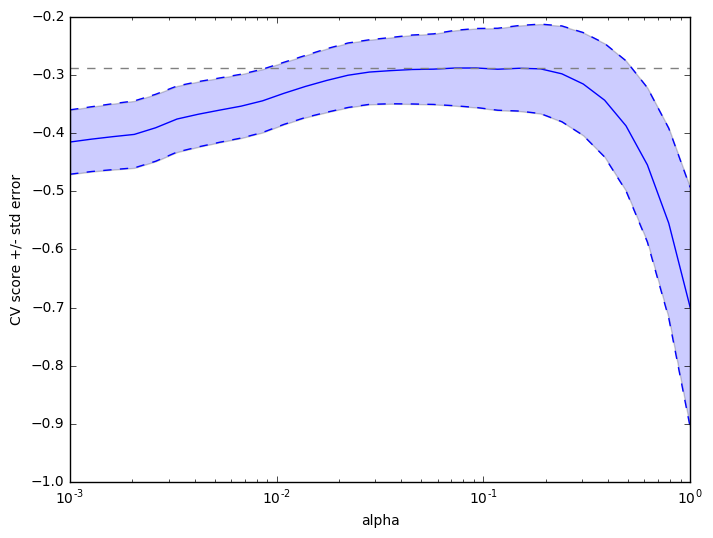

In [100]:
alphas = np.logspace(-3, 0, 30)
scores = list()
scores_std = list()
net = ElasticNet()
for alpha in alphas:
    net.alpha = alpha
    this_scores = cross_val_score(net, X, Y, cv=3, scoring='neg_mean_squared_error')
    #this_scores *= y_scaler.scale_**2
    scores.append(this_scores.mean())
    scores_std.append(this_scores.std())
scores, scores_std = np.array(scores), np.array(scores_std)

plot_scores(scores, scores_std, alphas, 'alpha')
max_score = np.max(scores)
max_alpha = alphas[scores==max_score][0]
print('Best score: {:.2f} (+/- {:.2f}) with alpha = {:f}'.format(
        -max_score, scores_std[scores==max_score][0]/np.sqrt(3), max_alpha))